In [77]:
# Select images set
SET = 'rot270'

----

In [78]:
import numpy as np
import pandas as pd
import os
import SimpleITK as sitk
from glob import glob

import matplotlib.pyplot as plt

### paths

In [79]:
data_path = '../dataset/'
SET_DIR = '../sets/' + SET + '/'
TRAIN_IMG_DIR = SET_DIR + 'nodules/train/'
TEST_IMG_DIR = SET_DIR + 'nodules/test/'
VAL_IMG_DIR = SET_DIR + 'nodules/val/'
IMG_PREF = 'nodule_'
IMG_EXT = '.jpg'

### read pickle

In [80]:
X_train = pd.read_pickle(SET_DIR + 'pickle/traindata')
X_test = pd.read_pickle(SET_DIR + 'pickle/testdata')
X_val = pd.read_pickle(SET_DIR + 'pickle/valdata')
y_train = pd.read_pickle(SET_DIR + 'pickle/trainlabels')
y_test = pd.read_pickle(SET_DIR + 'pickle/testlabels')
y_val = pd.read_pickle(SET_DIR + 'pickle/vallabels')

In [81]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  15113
Total positives:  4300.0
28.45 %


### create h5py files

In [82]:
import h5py
import PIL

In [83]:
def create_h5py(mode):
    if mode == 'train':
        X = X_train
        y = y_train
        DIR = TRAIN_IMG_DIR
    elif mode == 'test':
        X = X_test
        y = y_test
        DIR = TEST_IMG_DIR
    elif mode == 'val':
        X = X_val
        y = y_val
        DIR = VAL_IMG_DIR
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'w')
    
    # Create classes (labels) dataset
    f.create_dataset(mode + '_labels', shape = (len(y),))
    f[mode + '_labels'][...] = list(y)
    
    # Create images dataset
    f.create_dataset(mode + '_img', shape = (len(X), 50, 50))
    index = 0
    for col in X.transpose():
        image = PIL.Image.open(DIR + IMG_PREF + str(col) + IMG_EXT)
        f[mode + '_img'][index, ...] = image
        index += 1
    
    f.close()
    
    f = h5py.File('../h5py/malaCAD' + mode + '.hdf5', 'r')
    X_ret = f[mode + '_img'] [...]
    y_ret = f[mode + '_labels'][...]
    f.close()
    
    return (X_ret, y_ret)

In [84]:
input_train, label_train = create_h5py('train')
input_test, label_test = create_h5py('test')
input_val, label_val = create_h5py('val')

## CNN

In [85]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [87]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 50, 50, 1
loss_function = binary_crossentropy
no_classes = 1
no_epochs = 5
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [88]:
# Reshape data
input_train = input_train.reshape(len(input_train), img_width, img_height, img_num_channels)
input_test = input_test.reshape(len(input_test), img_width, img_height, img_num_channels)
input_val = input_val.reshape(len(input_val), img_width, img_height, img_num_channels)

input_shape = (img_width, img_height, img_num_channels)

In [89]:
print(len(input_train))
print(len(input_test))
print(len(input_val))

15113
2973
2973


In [90]:
# Create the model
model = Sequential()
model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(no_classes, activation='sigmoid'))

# Display a model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 50)        500       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        28864     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [91]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

### train model

In [ ]:
model.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=(input_val, label_val))

Train on 15113 samples, validate on 2973 samples
Epoch 1/5
 3450/15113 [=====>........................] - ETA: 1:32 - loss: 1.6176 - accuracy: 0.7310

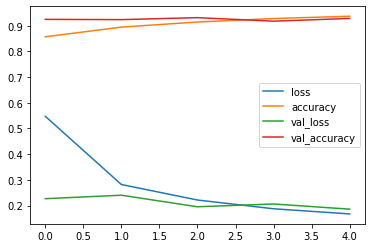

In [55]:
pd.DataFrame(model.history.history).plot()

### save model

In [56]:
model.save('../models/rot90_cnn_model.h5')

### predict

In [57]:
score = model.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.1203487484248808 / Test accuracy: 0.955600380897522


In [58]:
from sklearn.metrics import confusion_matrix, classification_report

preds = model.predict_classes(input_test)

print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

[[2649   92]
 [  40  192]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2741
         1.0       0.68      0.83      0.74       232

    accuracy                           0.96      2973
   macro avg       0.83      0.90      0.86      2973
weighted avg       0.96      0.96      0.96      2973

